In [1]:
import numpy as np
import tensorflow as tf

import sys
sys.path.append("..")

from models.regression_model import DemoRegressionDGP
from likelihoods import Gaussian
from utils_training import regression_train_demo

from matplotlib import pyplot as plt

2022-08-17 15:37:05.837586: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-08-17 15:37:06.756777: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-08-17 15:37:06.844622: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:25:00.0 name: NVIDIA RTX A5000 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 64 deviceMemorySize: 23.69GiB deviceMemoryBandwidth: 715.34GiB/s
2022-08-17 15:37:06.844652: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-08-17 15:37:06.847533: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-08-17 15:37:06.847665: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.

In [2]:
import pods
def get_mcycle_data(num_testing=100):
    data = pods.datasets.mcycle()
    X_train = data['X']
    y = data['Y']
    scale=np.sqrt(y.var())
    offset=y.mean()
    Y_train = (y - offset)/scale

    X_test = np.linspace(-20., 80., num_testing)[:, None]

    return np.float32(X_train), np.float32(Y_train), np.float(X_test)

X_train, Y_train, X_test = get_mcycle_data()
print(f"Number of training data: {np.shape(X_train)[0]}")
plt.plot(X_train[:,0], Y_train[:,0], "*")

def load_demo_data(num_testing):
    X_train, Y_train, X_test, Y_test= get_mcycle_data(num_testing)
    ds_X_train = tf.data.Dataset.from_tensor_slices(X_train)
    ds_Y_train = tf.data.Dataset.from_tensor_slices(Y_train)
    ds_train = tf.data.Dataset.zip((ds_X_train, ds_Y_train))
    ds_X_test = tf.data.Dataset.from_tensor_slices(X_test)
    ds_Y_test = tf.data.Dataset.from_tensor_slices(Y_test)
    ds_test = tf.data.Dataset.zip((ds_X_test, ds_Y_test))

    ds_train = ds_train.shuffle(num_training)
    # ds_test = ds_test.shuffle(num_testing)
    ds_train = ds_train.batch(num_training) # full data as one batch
    ds_test = ds_test.batch(num_testing)
    return ds_train, ds_test, X_test

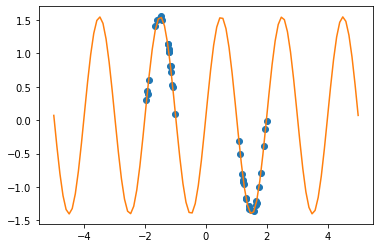

In [3]:
num_training = 30
num_testing = 100
gap = 0.1
std_noise = 0.1

ds_train, ds_test, X_test = load_demo_data(num_training, num_testing, gap=gap, std_noise=std_noise)
for x, y in ds_train:
    plt.plot(x[:,0], y[:,0], 'o',linewidth=0.5, label='training points')
for x, y in ds_test:
    plt.plot(x[:,0], y[:,0], label='ground truth')

# 1-layer GPs (fixing kernel params)

In [4]:
# initialize the model
d_in = 1
d_out = 1
model = DemoRegressionDGP(d_in, d_out, n_hidden_layers=1, n_rf=300, n_gp=1,
                          likelihood=Gaussian(variance=0.01, trainable=False),
                          kernel_type_list=['RBF'], kernel_trainable=False,
                          random_fixed=True, input_cat=False)

In [5]:
model.kernel_list[0].length_scale

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([4.], dtype=float32)>

In [6]:
# training settings
lr_0 = 0.02
beta = 0.99
total_epochs = 2000
start_sampling_epoch = 1000
epochs_per_cycle = 100
print_epoch_cycle = 20

In [7]:
_, _, lines, W = regression_train_demo(model, ds_train, ds_test, num_training, X_test,
                                                              lr_0=lr_0, momentum_decay=beta,
                                                              resample_in_cycle_head = True, total_epochs=total_epochs,
                                                              start_sampling_epoch=start_sampling_epoch,
                                                              epochs_per_cycle=epochs_per_cycle,
                                                              print_epoch_cycle=print_epoch_cycle)

2022-08-17 15:38:01.621415: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-08-17 15:38:01.646433: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-08-17 15:38:02.171973: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2022-08-17 15:38:02.172051: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Epoch: 19
Mean Log Likelihood -- train: -14.13392162322998, -- test: -233.3709716796875 
Root Mean Squared Error -- train: 0.5570918917655945, -- test: 2.166816234588623 
 
Epoch: 39
Mean Log Likelihood -- train: -30.722858428955078, -- test: -113.43569946289062 
Root Mean Squared Error -- train: 0.8013301491737366, -- test: 1.515383243560791 
 
Epoch: 59
Mean Log Likelihood -- train: -50.377655029296875, -- test: -85.17811584472656 
Root Mean Squared Error -- train: 1.0174604654312134, -- test: 1.31576406955719 
 
Epoch: 79
Mean Log Likelihood -- train: -31.302204132080078, -- test: -99.86966705322266 
Root Mean Squared Error -- train: 0.8085276484489441, -- test: 1.4230481386184692 
 
Epoch: 99
Mean Log Likelihood -- train: -11.46409797668457, -- test: -107.89253997802734 
Root Mean Squared Error -- train: 0.5069071650505066, -- test: 1.4783517122268677 
 
Epoch: 119
Mean Log Likelihood -- train: -17.666606903076172, -- test: -111.55237579345703 
Root Mean Squared Error -- train: 0.6

2022-08-17 15:38:10.625952: W tensorflow/core/kernels/data/model_dataset_op.cc:205] Optimization loop failed: Cancelled: Operation was cancelled


Epoch: 899
Mean Log Likelihood -- train: -7.762789726257324, -- test: -67.95037841796875 
Root Mean Squared Error -- train: 0.4277016520500183, -- test: 1.1775739192962646 
 
Epoch: 919
Mean Log Likelihood -- train: -7.765974521636963, -- test: -67.64532470703125 
Root Mean Squared Error -- train: 0.42777612805366516, -- test: 1.1749805212020874 
 
Epoch: 939
Mean Log Likelihood -- train: -7.777647495269775, -- test: -67.6074447631836 
Root Mean Squared Error -- train: 0.4280489385128021, -- test: 1.1746580600738525 
 
Epoch: 959
Mean Log Likelihood -- train: -7.7866950035095215, -- test: -67.8115463256836 
Root Mean Squared Error -- train: 0.4282602369785309, -- test: 1.1763943433761597 
 
Epoch: 979
Mean Log Likelihood -- train: -7.790836334228516, -- test: -67.5370101928711 
Root Mean Squared Error -- train: 0.42835691571235657, -- test: 1.1740583181381226 
 
Epoch: 999
Mean Log Likelihood -- train: -7.79068660736084, -- test: -67.81155395507812 
Root Mean Squared Error -- train: 0.

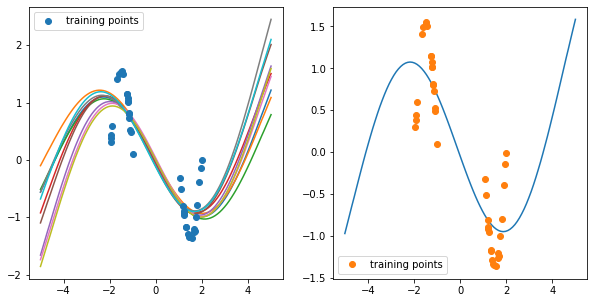

In [11]:
# print sampled lines
fig, ax = plt.subplots(1, model.n_hidden_layers+1, figsize=((model.n_hidden_layers+1)*5, 5))
ax = ax.flatten()
for i in range(model.n_hidden_layers):
    for model_line in lines[:]: # hidden outputs of each sampled model
        line = model_line[i]
        ax[i].plot(X_test[:,0], line.numpy()[:,0])
    # for model_line in lines[690:701]: # hidden outputs of each sampled model
    #     line = model_line[i]
    #     ax[i].plot(X_test.numpy()[:,0], line.numpy()[:,0], 'b')
for x, y in ds_train:
    ax[-2].plot(x[:,0], y[:,0], 'o', label='training points')
# for x, y in ds_test:
    # ax[-1].plot(x[:,0], y[:,0], '*', label='ground truth')
ax[-2].legend()

# compute the mean of the sampled lines
line_output = []
for model_line in lines[:]:
    line_output.append(model_line[-1]) #the final layer
line_mean = tf.reduce_mean(tf.concat(line_output, axis=-1), axis=-1)
ax[-1].plot(X_test[:,0], line_mean.numpy())
for x, y in ds_train:
    ax[-1].plot(x[:,0], y[:,0], 'o', label='training points')
ax[-1].legend()

# 2-layer DGPs (fixing kernel params)

In [19]:
# initialize the model
d_in = 1
d_out = 1
model = DemoRegressionDGP(d_in, d_out, n_hidden_layers=2, n_rf=300, n_gp=1,
                          likelihood=Gaussian(variance=0.01, trainable=False),
                          kernel_type_list=['RBF' for i in range(2)], kernel_trainable=False,
                          random_fixed=True, input_cat=False)

In [20]:
model.kernel_list[0].length_scale

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([4.], dtype=float32)>

In [21]:
# training settings
lr_0 = 0.01
beta = 0.95
total_epochs = 50000
start_sampling_epoch = 1000
epochs_per_cycle = 50
print_epoch_cycle = 50

In [22]:
_, _, lines, W = regression_train_demo(model, ds_train, ds_test, num_training, X_test,
                                                              lr_0=lr_0, momentum_decay=beta,
                                                              resample_in_cycle_head = True, total_epochs=total_epochs,
                                                              start_sampling_epoch=start_sampling_epoch,
                                                              epochs_per_cycle=epochs_per_cycle,
                                                              print_epoch_cycle=print_epoch_cycle)

Epoch: 49
Mean Log Likelihood -- train: -15.231321334838867, -- test: -85.19778442382812 
Root Mean Squared Error -- train: 0.5764541029930115, -- test: 1.3159135580062866 
 
Epoch: 99
Mean Log Likelihood -- train: -8.458148002624512, -- test: -105.99604797363281 
Root Mean Squared Error -- train: 0.4436618983745575, -- test: 1.4654669761657715 
 
Epoch: 149
Mean Log Likelihood -- train: -6.507208824157715, -- test: -82.1368637084961 
Root Mean Squared Error -- train: 0.39726200699806213, -- test: 1.2924435138702393 
 
Epoch: 199
Mean Log Likelihood -- train: -6.076657295227051, -- test: -89.41081237792969 
Root Mean Squared Error -- train: 0.38627201318740845, -- test: 1.3475492000579834 
 
Epoch: 249
Mean Log Likelihood -- train: -6.091355323791504, -- test: -92.86245727539062 
Root Mean Squared Error -- train: 0.3866523206233978, -- test: 1.3729246854782104 
 
Epoch: 299
Mean Log Likelihood -- train: -6.0499982833862305, -- test: -95.87023162841797 
Root Mean Squared Error -- train:

2022-08-17 15:43:34.416791: W tensorflow/core/kernels/data/model_dataset_op.cc:205] Optimization loop failed: Cancelled: Operation was cancelled


#################### Sampling at Epoch 4449  lr = 9.73450031693801e-09 ####################
Epoch: 4449
Mean Log Likelihood -- train: -6.029227256774902, -- test: -111.89976501464844 
Root Mean Squared Error -- train: 0.3850421607494354, -- test: 1.5052134990692139 
 
#################### Sampling at Epoch 4499  lr = 9.73450031693801e-09 ####################
Epoch: 4499
Mean Log Likelihood -- train: -6.040506839752197, -- test: -110.14572143554688 
Root Mean Squared Error -- train: 0.38533496856689453, -- test: 1.4935150146484375 
 
#################### Sampling at Epoch 4549  lr = 9.73450031693801e-09 ####################
Epoch: 4549
Mean Log Likelihood -- train: -6.166083335876465, -- test: -98.69305419921875 
Root Mean Squared Error -- train: 0.38858023285865784, -- test: 1.4147558212280273 
 
#################### Sampling at Epoch 4599  lr = 9.73450031693801e-09 ####################
Epoch: 4599
Mean Log Likelihood -- train: -5.836912631988525, -- test: -120.78286743164062 
Root Mea

2022-08-17 15:46:42.839900: W tensorflow/core/kernels/data/model_dataset_op.cc:205] Optimization loop failed: Cancelled: Operation was cancelled


#################### Sampling at Epoch 18599  lr = 9.73450031693801e-09 ####################
Epoch: 18599
Mean Log Likelihood -- train: -5.6308369636535645, -- test: -87.54435729980469 
Root Mean Squared Error -- train: 0.3745526373386383, -- test: 1.333626627922058 
 
#################### Sampling at Epoch 18649  lr = 9.73450031693801e-09 ####################
Epoch: 18649
Mean Log Likelihood -- train: -5.508543968200684, -- test: -107.1279067993164 
Root Mean Squared Error -- train: 0.3712732493877411, -- test: 1.4731703996658325 
 
#################### Sampling at Epoch 18699  lr = 9.73450031693801e-09 ####################
Epoch: 18699
Mean Log Likelihood -- train: -5.579087257385254, -- test: -95.0654067993164 
Root Mean Squared Error -- train: 0.373168408870697, -- test: 1.3888776302337646 
 
#################### Sampling at Epoch 18749  lr = 9.73450031693801e-09 ####################
Epoch: 18749
Mean Log Likelihood -- train: -5.67309045791626, -- test: -91.06658935546875 
Root Mea

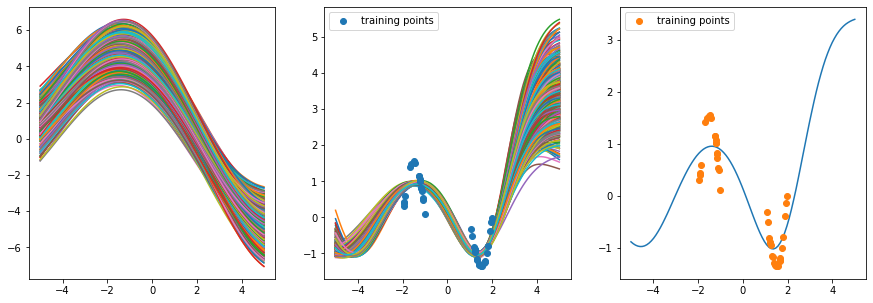

In [23]:
# print sampled lines
fig, ax = plt.subplots(1, model.n_hidden_layers+1, figsize=((model.n_hidden_layers+1)*5, 5))
ax = ax.flatten()
for i in range(model.n_hidden_layers):
    for model_line in lines[100:]: # hidden outputs of each sampled model
        line = model_line[i]
        ax[i].plot(X_test[:,0], line.numpy()[:,0])
    # for model_line in lines[690:701]: # hidden outputs of each sampled model
    #     line = model_line[i]
    #     ax[i].plot(X_test.numpy()[:,0], line.numpy()[:,0], 'b')
for x, y in ds_train:
    ax[-2].plot(x[:,0], y[:,0], 'o', label='training points')
# for x, y in ds_test:
    # ax[-1].plot(x[:,0], y[:,0], '*', label='ground truth')
ax[-2].legend()

# compute the mean of the sampled lines
line_output = []
for model_line in lines[100:]:
    line_output.append(model_line[-1]) #the final layer
line_mean = tf.reduce_mean(tf.concat(line_output, axis=-1), axis=-1)
ax[-1].plot(X_test[:,0], line_mean.numpy())
for x, y in ds_train:
    ax[-1].plot(x[:,0], y[:,0], 'o', label='training points')
ax[-1].legend()

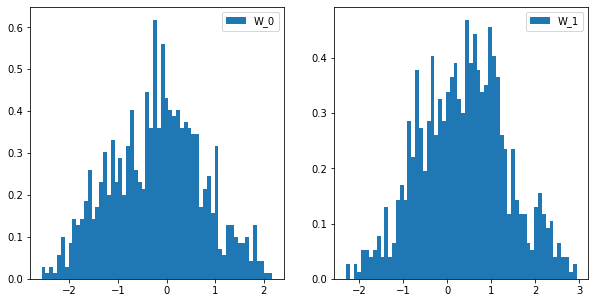

In [24]:
print_index = (0,0)
fig, ax = plt.subplots(1, model.n_hidden_layers, figsize=(model.n_hidden_layers*5,5))
ax = ax.flatten()
for i in range(model.n_hidden_layers):
    W_print = []
    for W_model in W['W_'+str(i)][100:]:
        W_print.append(W_model[print_index])
    ax[i].hist(W_print, bins=60, density=True, label='W_'+str(i))
    ax[i].legend()